# Exercises

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np
import pickle
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import warnings
warnings.filterwarnings('ignore')

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})

### Exercise 1
---
Use the sklearn `make_blobs()` function, in the same way that we used in the lesson, to generate a *non linearly separable* dataset with 2 features.  
Fit a linear SVM to the dataset many times, varying the slack hyperparameter $C$, and calculate the model performance in classifying the data.  
What is, approximately, the best value of the $C$ hyperparameter for this dataset?

In [2]:
# Create a non linearly separable dataset
X_nsep,y_nsep = make_blobs(n_samples=100,n_features =2,centers=[[-2,1],[1,0]],cluster_std=1.5,)

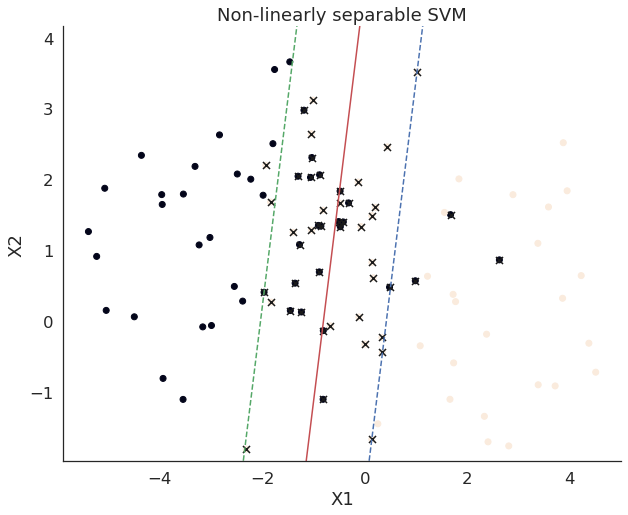

In [3]:
# Construct Support Vector Machine plot 
plt.figure(figsize=(10,8))
X,y = X_nsep,y_nsep
svc_model = svm.SVC(kernel='linear',C=1); # C is the hyperparamater, by default its value is 1
svc_model.fit(X, y)
plt.title('Non-linearly separable SVM')

# Plot the generated dataset
plt.scatter(X[:,0],X[:,1],c=y_nsep)

# Construct a hyperplane 
w = svc_model.coef_[0]           # w consists of 2 elements
b = svc_model.intercept_[0]      # b consists of 1 element
x_points = np.linspace(-4,2)    # generating x-points from -4 to 2
y_points = -(w[0] / w[1]) * x_points - b / w[1]  # getting corresponding y-points

# Plotting a red hyperplane
plt.plot(x_points, y_points, c='r');

# Encircle support vectors
plt.scatter(svc_model.support_vectors_[:, 0],
            svc_model.support_vectors_[:, 1], 
            s=50, 
            c='k',
            marker='x');

# # Divide the dual coefficients by their norm:
w_hat = svc_model.coef_[0] / (np.sqrt(np.sum(svc_model.coef_[0] ** 2))) # Calculating the norm constraint

# Calculate the margin:
margin = 1 / np.sqrt(np.sum(svc_model.coef_[0] ** 2))

# Calculate the points of the margin lines:
decision_boundary_points = np.array(list(zip(x_points, y_points)))
points_of_line_above = decision_boundary_points + w_hat * margin
points_of_line_below = decision_boundary_points - w_hat * margin

## Plot margin lines
# Blue margin line above
plt.plot(points_of_line_above[:, 0], 
         points_of_line_above[:, 1], 
         'b--')
# Green margin line below
plt.plot(points_of_line_below[:, 0], 
         points_of_line_below[:, 1], 
         'g--')

plt.ylim([min(X[:,1])+0.5,max(X[:,1])+0.5])

plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

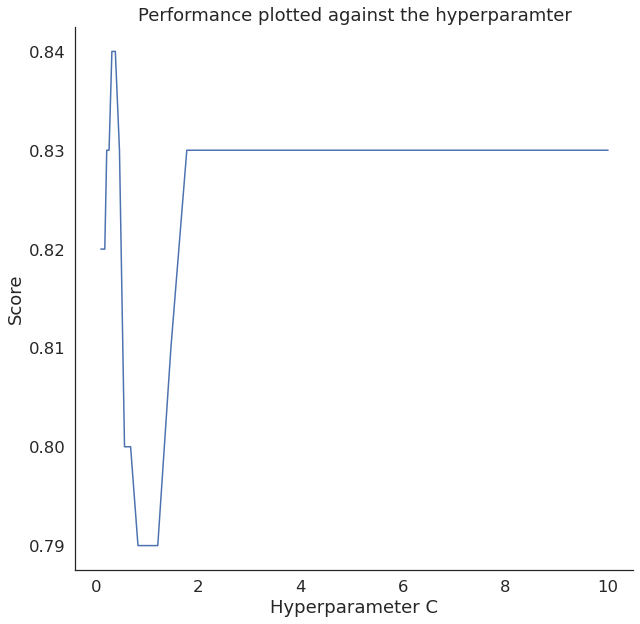

In [11]:
## Performance check
X,y = X_nsep,y_nsep
svc_model = svm.SVC(kernel='linear',C=100); # C is the hyperparamater, by default its value is 1
svc_model.fit(X,y)
svc_model.score(X, y)

C = np.logspace(0.0,2,25)/10
performance = []
iterations = 20

for i in C:
    score = 0
    for j in range(iterations):
        svc_model = svm.SVC(kernel='linear',C=i); # C is the hyperparamater, by default its value is 1
        svc_model.fit(X,y)
        score += svc_model.score(X, y)
    performance.append(score/iterations)

plt.figure(figsize=(10,10))
plt.plot(C,performance)
plt.title('Performance plotted against the hyperparamter')
plt.xlabel('Hyperparameter C')
plt.ylabel('Score')
plt.show()

The hyperparameter does not seem to have a great influence on the performance of the SVM model, however increasing the hyperparamter does seem to stabilize the performance score. By default the hyperparameter is set to 1, but for a more stable outcome I think it would be better to set it higher, i.e. to 5. This will increase the calculation time a bit.

### Exercise 2
---
Repeat exercise 1, but using a non-linear SVM model (the sklearn class `SVC` uses [Radial Basis Functions](https://en.wikipedia.org/wiki/Radial_basis_function) as a default, check its documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)). 
To have a fairer assessment of the performance, train the model on a fraction (e.g. 80%) of the data, and test it on the other 20%.
Compare the performance of a linear SVC and a RBF SVC for dataset that are increaslingly non-linearly-separable.


### Exercise 3
---
Use the code below to simulate new data.
Generate data and then decode the stimulus identity, see how the decoding performance change when you change the following:

- The amplitude of the noise in the firing rate
- The amplitude of the stimulus modulation of the firing rate
- The number of neurons

Plot and comment.

## Useful code
---


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [6]:
n_cells = 20; # number of cells to simulate
n_stim_type = 2; # number of different stimuli
sigma_stim = 0.5 # amplitude of stimulus related modulation
average_firing_rate = 5; # average firing rate across the population

# generate baseline rates from exponential distirbution
cell_rate_baseline = np.random.exponential(average_firing_rate,size=n_cells)

# create stimulus average responses, perturbing the population firng rate profile
# we use a multiplicative modulation in opposite directions for the two stimuli
modulation = sigma_stim*np.random.normal(0,1,size=n_cells)
cell_rate_stim = {1: cell_rate_baseline * (1+modulation),2:cell_rate_baseline * (1-modulation)}
# sets negative firng rate to 0
cell_rate_stim[1][cell_rate_stim[1]<0]=0
cell_rate_stim[2][cell_rate_stim[2]<0]=0

In [7]:
# simulate spiking activity

s_rate = 10000 # the sampling rate of our emulated recording system
noise_rate = 1 # we are going to add some spike noise non related to the task
n_stim = 100 # number of stimuli

stim_dur = 2 #stimulus duration (in seconds)
is_interval = 3 # interval between stimuli  (in seconds)

stim_onsets = np.arange(0,n_stim*(stim_dur+is_interval),(stim_dur+is_interval)) # onset time of each stimulus (in seconds)
stim_type = np.asarray([1 for i in range(int(n_stim/2))]+[2 for i in range(int(n_stim/2))]) # identity of each stimulus
np.random.shuffle(stim_type)

time = np.arange(0,(n_stim+1)*(stim_dur+is_interval),1.0/s_rate) # vector of the sampled times.

spike_times = []
for cell in range(n_cells):
    spikes = np.random.poisson(cell_rate_baseline[cell]/s_rate,size=time.shape)
    for i,stimulus in enumerate(stim_type):
        stim_idxs = np.arange(stim_onsets[i]*s_rate,(stim_onsets[i]+stim_dur)*s_rate)
        spikes[stim_idxs] = np.random.poisson(cell_rate_stim[stimulus][cell]/s_rate,size=stim_idxs.shape)

    spike_times.append(time[spikes>0])



In [8]:
# save ouput
out_dict = {'spike_times':spike_times,
            'stim_onsets':stim_onsets,
            'stim_type':stim_type,
            'stim_duration':stim_dur
            }

with open('data/simulated_data1.pickle', 'wb') as handle:
    pickle.dump(out_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
